# NNDL HomeWork#03

## 0) Preparation

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 20.0 MB/s 


In [19]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.functional as F
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os
from PIL import Image
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassPrecision
)


%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cuda


## 1) Introduction to transfer learning

### I. Preprocessing

In [ ]:
# getting the data
!wget -q https://warwick.ac.uk/fac/cross_fac/tia/data/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip -O dataset.zip
# unzip thethe file
!unzip -q dataset.zip
%cd Warwick\ QU\ Dataset\ \(Released\ 2016_07_08\)

/content/Warwick QU Dataset (Released 2016_07_08)


In [ ]:
grade = pd.read_csv("Grade.csv")
grade

,name,patient ID,grade (GlaS),grade (Sirinukunwattana et al. 2015)
0,testA_1,4,benign,adenomatous
1,testA_10,10,benign,healthy
2,testA_11,9,benign,healthy
3,testA_12,11,malignant,poorly differentiated
4,testA_13,7,malignant,moderately differentiated
...,...,...,...,...
160,train_82,2,malignant,moderately-to-poorly differentated
161,train_83,11,malignant,poorly differentiated
162,train_84,15,benign,healthy
163,train_85,10,benign,healthy


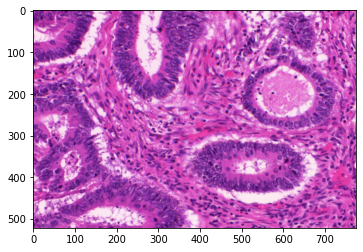

In [ ]:
photo = plt.imread("train_1.bmp")
plt.imshow(photo)
plt.show()

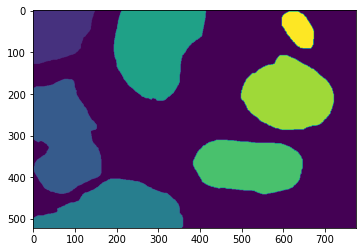

In [ ]:
photo_anno = plt.imread("train_1_anno.bmp")
plt.imshow(photo_anno)
plt.show()

Now extracting images and labels of train and test

In [ ]:
y_testA_list = []
y_testB_list = []
y_train_list = []
X_testA_list = []
X_testB_list = []
X_train_list = []

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.226])
])

for row in grade.iterrows():
  name = row[1]['name']

  label = 0                                         # benign
  if row[1][" grade (GlaS)"] == " malignant":
    label = 1                                       # malignant
  
  input_image = Image.open(f"{name}.bmp")
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if(name.startswith("testA")):
    y_testA_list.append(label)
    X_testA_list.append(input_batch)
  elif(name.startswith("testB")):
    y_testB_list.append(label)
    X_testB_list.append(input_batch)
  else:
    y_train_list.append(label)
    X_train_list.append(input_batch)

# Convert to tensors
y_testA = torch.tensor(y_testA_list).type(dtype=torch.LongTensor)
y_testB = torch.tensor(y_testB_list).type(dtype=torch.LongTensor)
y_train = torch.tensor(y_train_list).type(dtype=torch.LongTensor)
X_testA = torch.cat(X_testA_list)
X_testB = torch.cat(X_testB_list)
X_train = torch.cat(X_train_list)


In [ ]:
class CancerDataset(Dataset):
  def __init__(self, X: torch.Tensor, y: torch.Tensor):
    super().__init__()
    self.input = X
    self.target = y

  def __getitem__(self, idx):
    return self.input[idx], self.target[idx]
  
  def __len__(self):
    return self.input.shape[0]

In [ ]:
train_dataset = CancerDataset(X_train, y_train)
testA_dataset = CancerDataset(X_testA, y_testA)
testB_dataset = CancerDataset(X_testB, y_testB)

### II. Import the model

First load the standard Resnet50

In [ ]:
class CustomResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet = torch.hub.load("pytorch/vision:v0.10.0", "resnet50", pretrained=True)
    self.output_layer = nn.Linear(1000, 2)

  def forward(self, x):
    x = self.resnet(x)
    x = self.output_layer(x)
    return x

We need to define a output layer because the dataset has two labels

### III. Training

Make hyper parameters

In [ ]:
LEARNING_RATE = 0.002
MOMENTUM = 0.5
EPOCHS = 100
BATCH_SIZE = 16

In [ ]:
model = CustomResNet()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=LEARNING_RATE,
                            momentum=MOMENTUM)


train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE, shuffle=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1])

In [ ]:
multi_accuracy = MulticlassAccuracy(num_classes=2).to(device)
multi_f1 = MulticlassF1Score(num_classes=2).to(device)
multi_precision = MulticlassPrecision(num_classes=2).to(device)

In [ ]:
# learning loop
losses = []
accuracies = []

for epoch in range(1, EPOCHS+1):
  outputs = []
  targets = []
  print(f"***** Epoch {epoch} *****")
  for i, (inputs, target) in enumerate(train_dataloader):
    
    inputs = inputs.to(device)
    target = target.to(device)

    predicted = model(inputs)
    
    optimizer.zero_grad()
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()

    outputs.append(predicted)
    targets.append(target)
  

  outputs = torch.cat(outputs)
  targets = torch.cat(targets)
  accuracy = multi_accuracy(outputs, targets)
  losses.append(loss.item())
  accuracies.append(accuracy.item())
  print(f"Loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}")

***** Epoch 1 *****
Loss: 0.137, Accuracy: 0.717
***** Epoch 2 *****
Loss: 0.250, Accuracy: 0.952
***** Epoch 3 *****
Loss: 0.112, Accuracy: 0.979
***** Epoch 4 *****
Loss: 0.139, Accuracy: 1.000
***** Epoch 5 *****
Loss: 0.002, Accuracy: 1.000
***** Epoch 6 *****
Loss: 0.008, Accuracy: 1.000
***** Epoch 7 *****
Loss: 0.510, Accuracy: 0.973
***** Epoch 8 *****
Loss: 0.006, Accuracy: 1.000
***** Epoch 9 *****
Loss: 0.001, Accuracy: 0.990
***** Epoch 10 *****
Loss: 0.013, Accuracy: 1.000
***** Epoch 11 *****
Loss: 0.076, Accuracy: 1.000
***** Epoch 12 *****
Loss: 1.706, Accuracy: 0.973
***** Epoch 13 *****
Loss: 0.299, Accuracy: 0.986
***** Epoch 14 *****
Loss: 0.230, Accuracy: 0.986
***** Epoch 15 *****
Loss: 1.966, Accuracy: 0.927
***** Epoch 16 *****
Loss: 0.001, Accuracy: 0.990
***** Epoch 17 *****
Loss: 0.019, Accuracy: 1.000
***** Epoch 18 *****
Loss: 0.005, Accuracy: 1.000
***** Epoch 19 *****
Loss: 0.000, Accuracy: 1.000
***** Epoch 20 *****
Loss: 0.012, Accuracy: 1.000
***** Epo

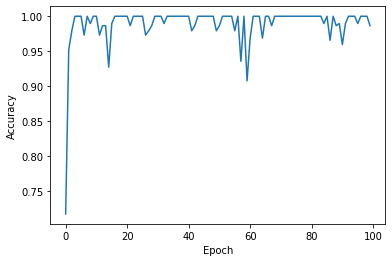

In [ ]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### VI. Test

Testing on `TestA` dataset

In [ ]:
with torch.no_grad():
  X_testA = X_testA.to(device)
  y_testA = y_testA.to(device)
  predictedA = model(X_testA)
  acc = multi_accuracy(predictedA, y_testA)
  prec = multi_precision(predictedA, y_testA)
  f1 = multi_f1(predictedA, y_testA)
  print(f"Accuracy: {acc.item():.3f}, Precision: {prec.item():.3f}, F1 Score: {f1.item():.3f}")

Accuracy: 0.939, Precision: 0.935, F1 Score: 0.933


Testing on `TestB` dataset

In [ ]:
with torch.no_grad():
  X_testB = X_testB.to(device)
  y_testB = y_testB.to(device)
  predictedB = model(X_testB)
  acc = multi_accuracy(predictedB, y_testB)
  prec = multi_precision(predictedB, y_testB)
  f1 = multi_f1(predictedB, y_testB)
  print(f"Accuracy: {acc.item():.3f}, Precision: {prec.item():.3f}, F1 Score: {f1.item():.3f}")

Accuracy: 0.906, Precision: 0.786, F1 Score: 0.812


## 2) Introduction to occluded face recognition

## 3) Realtime object recognition

### 1) Prepration YOLOv6

In [32]:
# If using google colab import Yolov6_chess.zip to colab 
!unzip -q YoloV6_Chess.zip
!git clone https://github.com/meituan/YOLOv6
%mv YoloV6_Chess/* YOLOv6/
%cd YOLOv6/
!pip install -r requirements.txtive
# drive.mount('/content/drive')

[YoloV6_Chess.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of YoloV6_Chess.zip or
        YoloV6_Chess.zip.zip, and cannot find YoloV6_Chess.zip.ZIP, period.
Cloning into 'YOLOv6'...
remote: Enumerating objects: 2543, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2543 (delta 0), reused 1 (delta 0), pack-reused 2540
Receiving objects: 100% (2543/2543), 32.91 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (1407/1407), done.
mv: cannot stat 'YoloV6_Chess/*': No such file or directory
/content/YOLOv6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


clone the YOLOv6 from github

### 2) Train

In [49]:
!python tools/train.py --batch 32 --epochs 100 --conf configs/yolov6s.py --data data.yaml --device 0

Using 1 GPU for training... 
training args are: Namespace(batch_size=32, calib=False, check_images=False, check_labels=False, conf_file='configs/yolov6s.py', data_path='data.yaml', device='0', dist_url='env://', distill=False, distill_feat=False, epochs=100, eval_final_only=False, eval_interval=20, gpu_count=0, heavy_eval_range=50, img_size=640, local_rank=-1, name='exp', output_dir='./runs/train', quant=False, rank=-1, resume=False, save_ckpt_on_last_n_epoch=-1, save_dir='runs/train/exp4', stop_aug_last_n_epoch=15, teacher_model_path=None, temperature=20, workers=8, world_size=1, write_trainbatch_tb=False)

Train: Final numbers of valid images: 606/ labels: 606. 
0.0s for dataset initialization.
Convert to COCO format
100% 58/58 [00:00<00:00, 36130.94it/s]
Convert to COCO format finished. Resutls saved in ./annotations/instances_valid.json
Val: Final numbers of valid images: 58/ labels: 58. 
0.0s for dataset initialization.
Model: Model(
  (backbone): EfficientRep(
    (stem): RepVGGB

### 3) Inference

Now infer two test images

In [47]:
!python tools/infer.py --weights runs/train/exp3/weights/best_ckpt.pt --source images/test/a3863d0be6002c21b20ac88817b2c56f_jpg.rf.0413d5178136ace55f588df9556c060a.jpg
!python tools/infer.py --weights runs/train/exp3/weights/best_ckpt.pt --source images/test/0b47311f426ff926578c9d738d683e76_jpg.rf.40183eae584a653181bbd795ba3c353f.jpg

Namespace(agnostic_nms=False, classes=None, conf_thres=0.4, device='0', half=False, hide_conf=False, hide_labels=False, img_size=[640, 640], iou_thres=0.45, max_det=1000, name='exp', not_save_img=False, project='runs/inference', save_dir=None, save_txt=False, source='images/test/a3863d0be6002c21b20ac88817b2c56f_jpg.rf.0413d5178136ace55f588df9556c060a.jpg', view_img=False, weights='runs/train/exp3/weights/best_ckpt.pt', yaml='data/coco.yaml')
Save directory already existed
Loading checkpoint from runs/train/exp3/weights/best_ckpt.pt

Fusing model...
Switch model to deploy modality.
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100% 1/1 [00:00<00:00, 23.48it/s]
Results saved to runs/inference/exp
Namespace(agnostic_nms=False, c

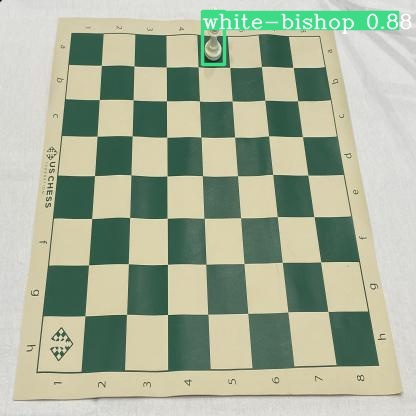

In [48]:
from IPython.display import Image
Image(filename='/content/YOLOv6/runs/inference/exp/0b47311f426ff926578c9d738d683e76_jpg.rf.40183eae584a653181bbd795ba3c353f.jpg', width=1000)

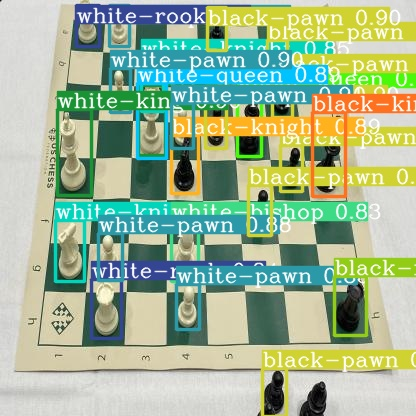

In [44]:
from IPython.display import Image
Image(filename='/content/YOLOv6/runs/inference/exp/a3863d0be6002c21b20ac88817b2c56f_jpg.rf.0413d5178136ace55f588df9556c060a.jpg', width=1000)